## Interpreting what convnets learn

In [1]:
import os
import pathlib
import numpy as np

import tensorflow as tf

import matplotlib.cm as cm
import matplotlib.pyplot as plt

from IPython.display import clear_output
from IPython.core.magic import register_cell_magic

os.environ["KERAS_BACKEND"] = "jax"

import keras
import keras_hub

@register_cell_magic
def backend(line, cell):
    current, required = os.environ.get("KERAS_BACKEND", ""), line.split()[-1]
    if current == required:
        get_ipython().run_cell(cell)
    else:
        print(
            f"This cell requires the {required} backend. To run it, change KERAS_BACKEND to "
            f"\"{required}\" at the top of the notebook, restart the runtime, and rerun the notebook."
        )

Not all deep learning models are 'black boxes' harbouring incomprehensible representations.

Convnets representations are easily visualised because convnets learn visual concepts.

We will cover three of the most accessible and useful convnet visualistion techniques.

1. Visualizing **intermediate activations** (layer outputs). Helps to understand how successive convnet layers transform their input;
2. Visualizing **convnets filters** – each filter is receptive to a particular visual pattern or concept;
3. Visualizing **heatmaps of class activation in an image** – which parts of an image were important in identification. Heatmaps enable localisation of objects in images.

---

## Visualising intermediate activations

This technique is simply the visualisation of the output (activation) of a particular feature map (filter) for a particular input image.

This demonstrates how the network filters deconstruct an image.

Feature maps have 3 dimensions: width, height, and depth (channels).

Each channel encodes relatively independent features – a good way to visualise these feature maps is to display the contents of every channel as a 2D image.

Let's start by loading the model that we saved in section 8.2:

### Retrieve models from your Google drive



2. Connect to your drive
```python
from google.colab import drive
drive.mount('/content/drive')
```

3. Copy the zip from your drive (adjust the directory), and unzip it

    ```bash
    !cp drive/MyDrive/gold/IS53024B-Artificial-Intelligence/models/dogs-vs-cats.models.zip  .
    !unzip -q dogs-vs-cats.models.zip
    ```




### Loading model

In [7]:
MODELS_DIR = pathlib.Path("models")

if not MODELS_DIR.exists():
    print("First run the notebook `8.introduction-to-convnets.ipynb`, save the models")
    print("locally or to your drive, then upload them here!")
else:
    model = keras.models.load_model(
        MODELS_DIR / "convnet_from_scratch_with_augmentation.keras"
    )

In [8]:
model.summary(line_length=80)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 15, 15, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 5, 5, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           6,401 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,969,796 (7.51 MB)

 Trainable params: 984,897 (3.76 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 984,899 (3.76 MB)

Here is our input image, a cat.

In [19]:
img_path = keras.utils.get_file(
    fname="chollet/cat.jpg",
    origin="https://raw.githubusercontent.com/jchwenger/AI/main/lectures/05/images/chollet/cat.jpg"
)

def get_img_array(img_path, target_size):
    img = keras.utils.load_img(
        img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

img_tensor = get_img_array(img_path, target_size=(180, 180))

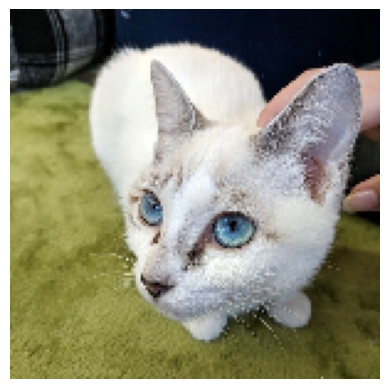

In [20]:
plt.axis("off")
plt.imshow(img_tensor[0].astype("uint8"))
plt.show()

We require a model that outputs the activations of all convolution and pooling layers.

Our model (functional syntax again) has one input and 9 outputs, one output per layer activation.

In [21]:
# ↓ DEFINITION OF OUR NEW MODEL -------------------------------------------------
layer_outputs = []                 # the outputs we want from the model
layer_names = []
for layer in model.layers:         # loop through all layers
    # only select layers if they are a Conv2D or a MaxPooling2D
    if isinstance(layer, (keras.layers.Conv2D, keras.layers.MaxPooling2D)):
        layer_outputs.append(layer.output) # append the layer output
        layer_names.append(layer.name)
# ↑ -----------------------------------------------------------------------------

# functional syntax: by passing our list layer_outputs to the outputs
# parameters, we create a model that returns its inner activations
activation_model = keras.Model(
    inputs=model.input,            # here 'model' is our existing model: same inputs
    outputs=layer_outputs          # the outputs we want from the model
)

The outputs are accessed by `model.predict()`

In [22]:
# This will return a list of 9 Numpy arrays:
# one array per layer activation
activations = activation_model.predict(img_tensor)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


The activation of the first convolution layer has shape

In [23]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)     # shape: (batch_size, width, height, channels)

(1, 148, 148, 32)


A 148 x 148 feature map with 32 channels

Let's try visualizing the 3rd channel:

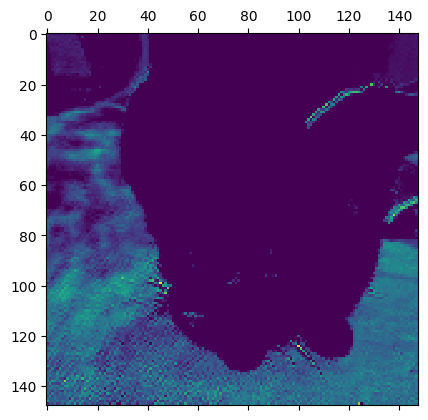

In [24]:
plt.matshow(first_layer_activation[0, :, :, 3], cmap='viridis') # diagonal edge detector?

Let's try channel 19 (channels vary, since the filters learned by conv layers are not deterministic).

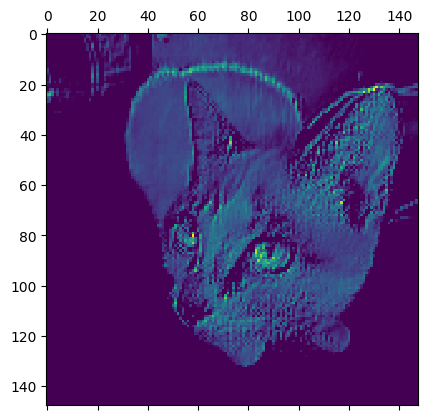

In [25]:
plt.matshow(first_layer_activation[0, :, :, 19], cmap='viridis')
plt.show()

Now we will extract and plot every channel in each of our 9 activation maps  
– stack the results in one big image tensor, with channels stacked side by side.

In [43]:
def plot_layer_activations():
    images_per_row = 16
    for layer_name, layer_activation in zip(layer_names, activations):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros(                                                   # 1. create a grid as an empty
            ((size + 1) * n_cols - 1, images_per_row * (size + 1) - 1)             #    NumPy array
        )
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_index = col * images_per_row + row
                channel_image = layer_activation[0, :, :, channel_index].copy()
                if channel_image.sum() != 0:                                       # 2. normalise the channel image,
                    channel_image -= channel_image.mean()
                    channel_image /= channel_image.std()
                    channel_image *= 64
                    channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype("uint8")     #    and clip → [0,255] pixel values
                display_grid[
                    col * (size + 1) : (col + 1) * size + col,
                    row * (size + 1) : (row + 1) * size + row,                     # 3. at the correct indices
                ] = channel_image                                                  #    assign the image pixels
        scale = 1.0 / size
        plt.figure(
            figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]) # 4. display the grid
        )
        plt.title(layer_name)
        plt.grid(False)
        plt.axis("off")
        plt.imshow(display_grid, aspect="auto", cmap="viridis")


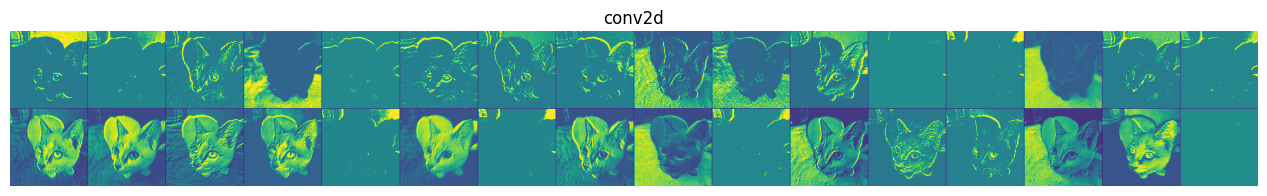

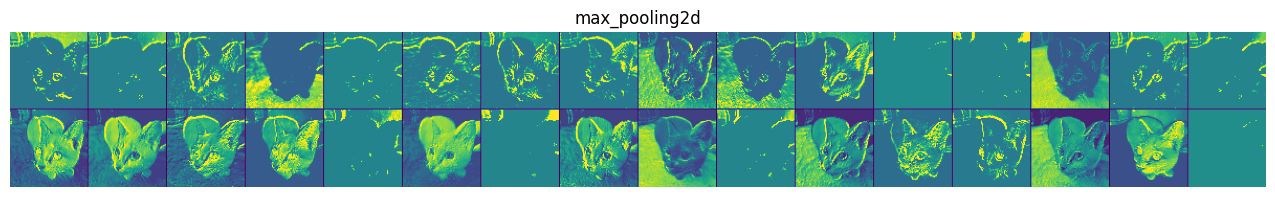

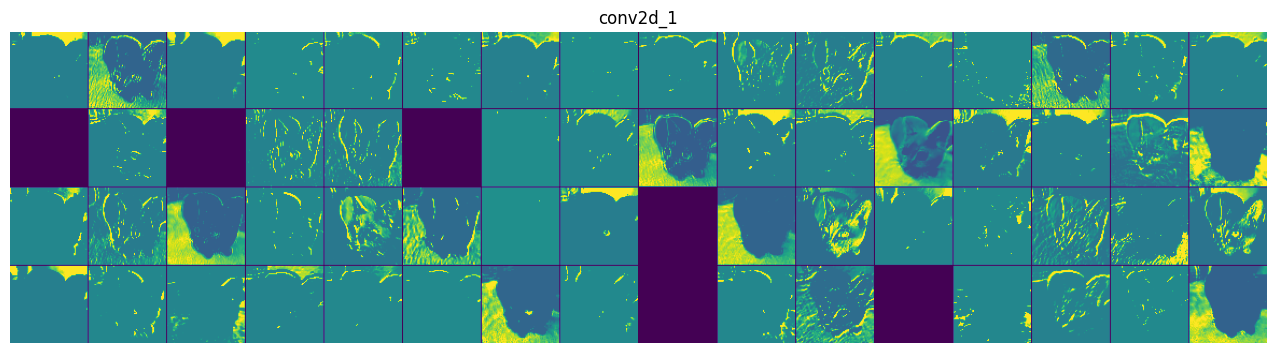

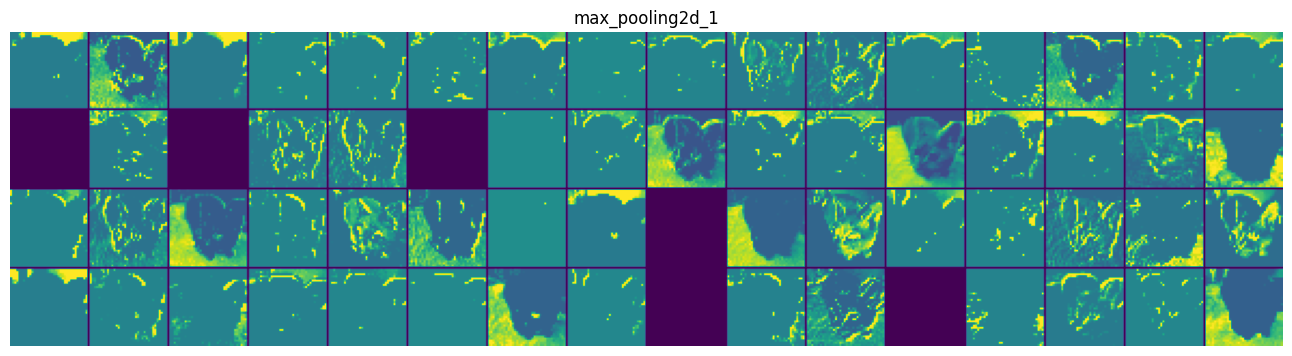

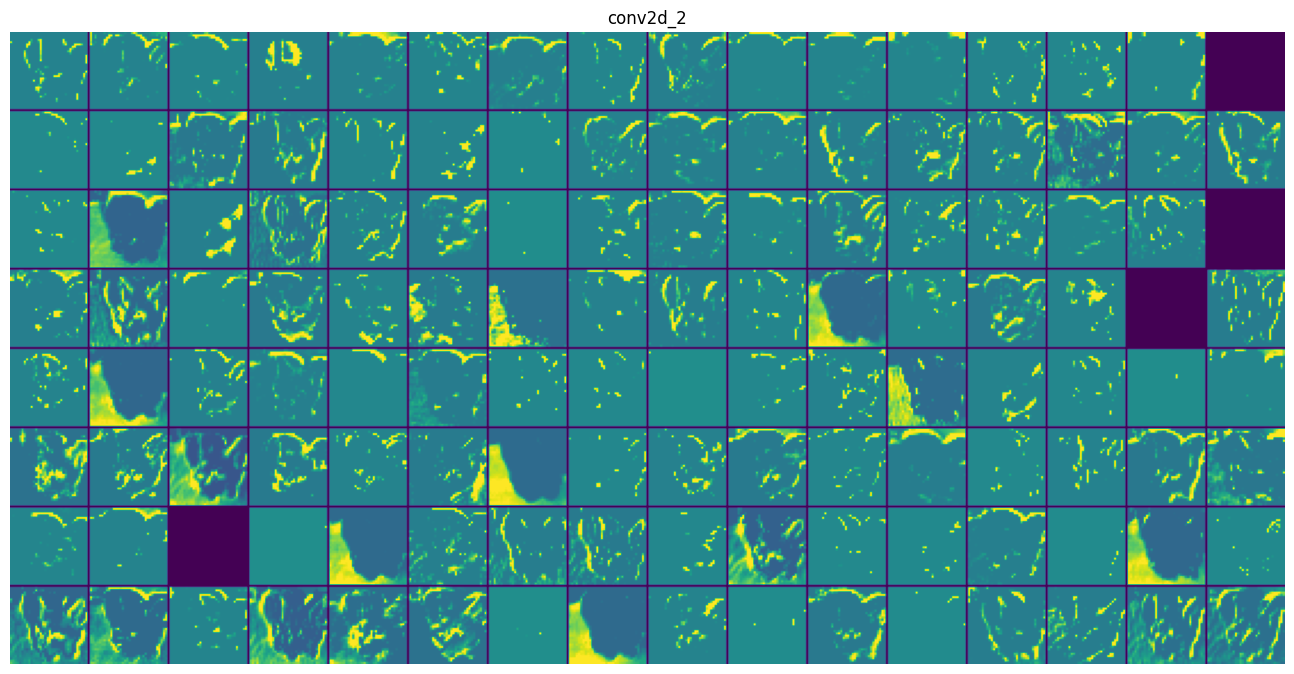

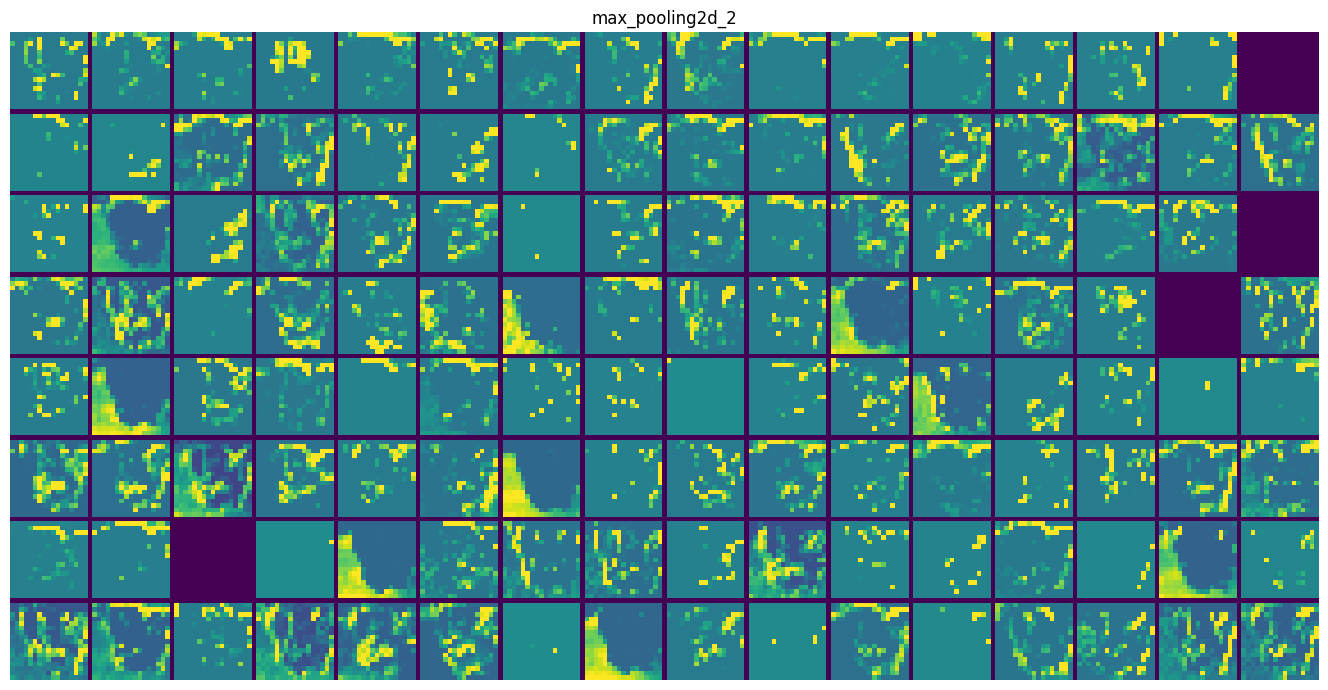

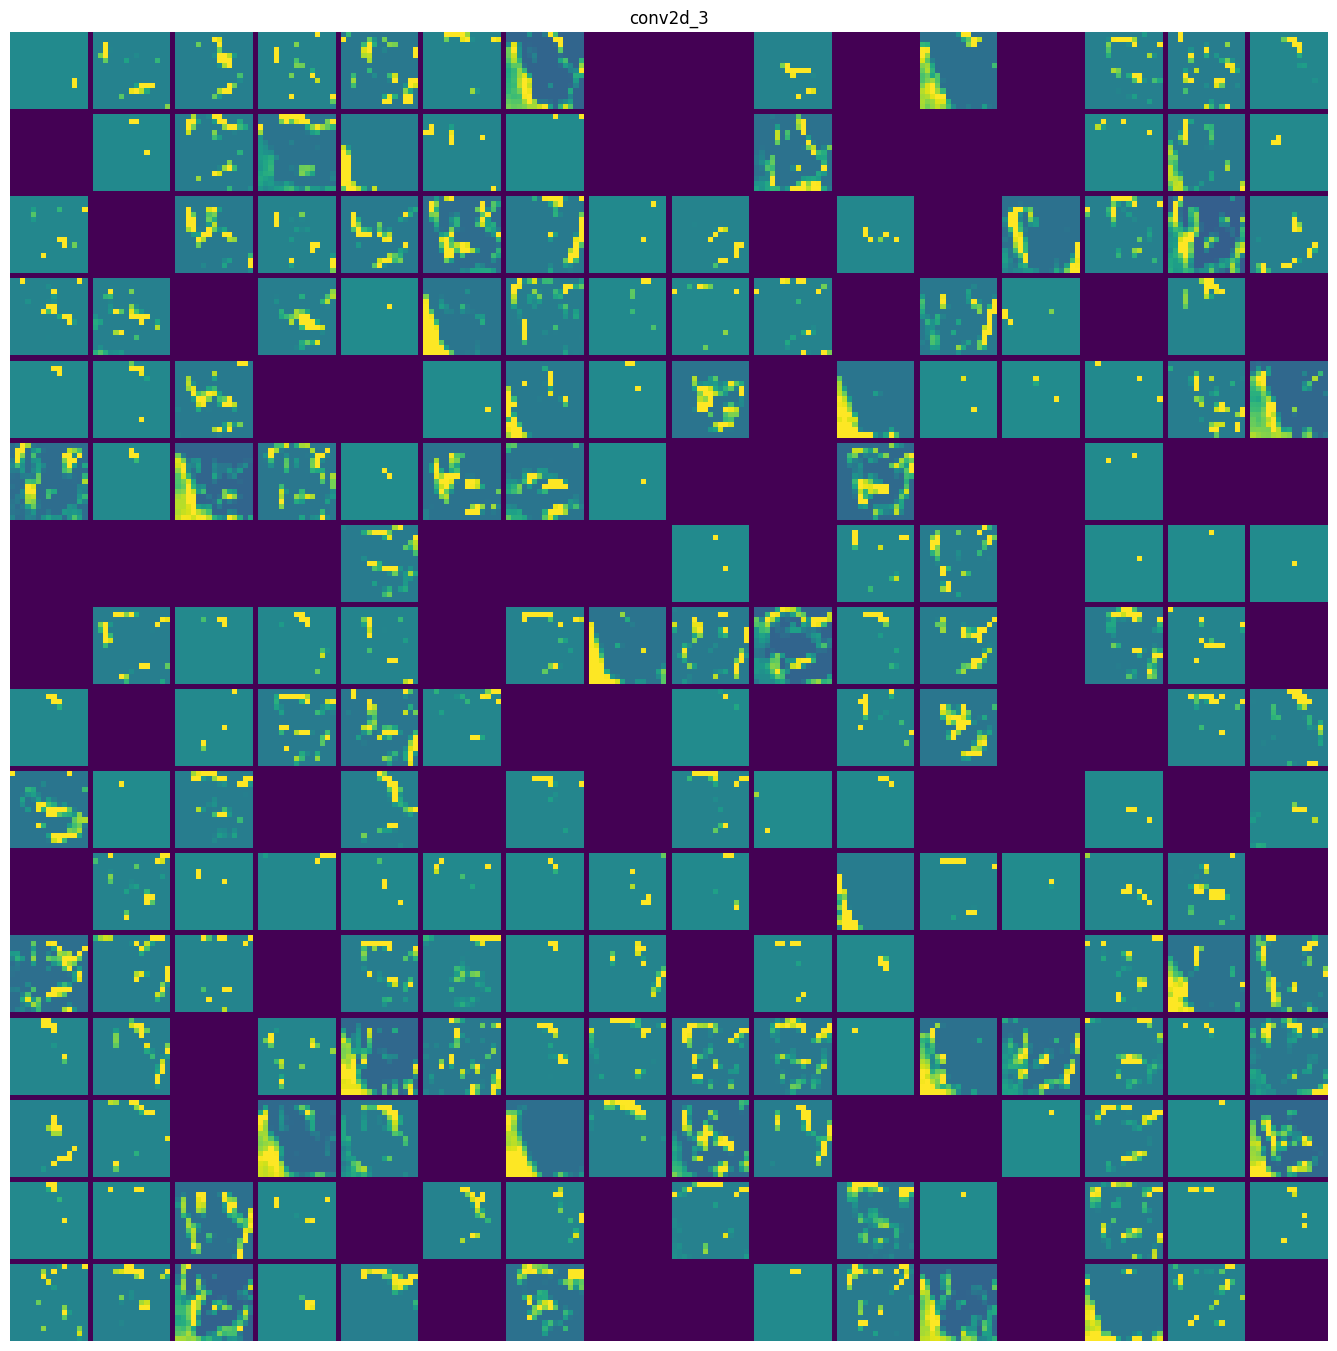

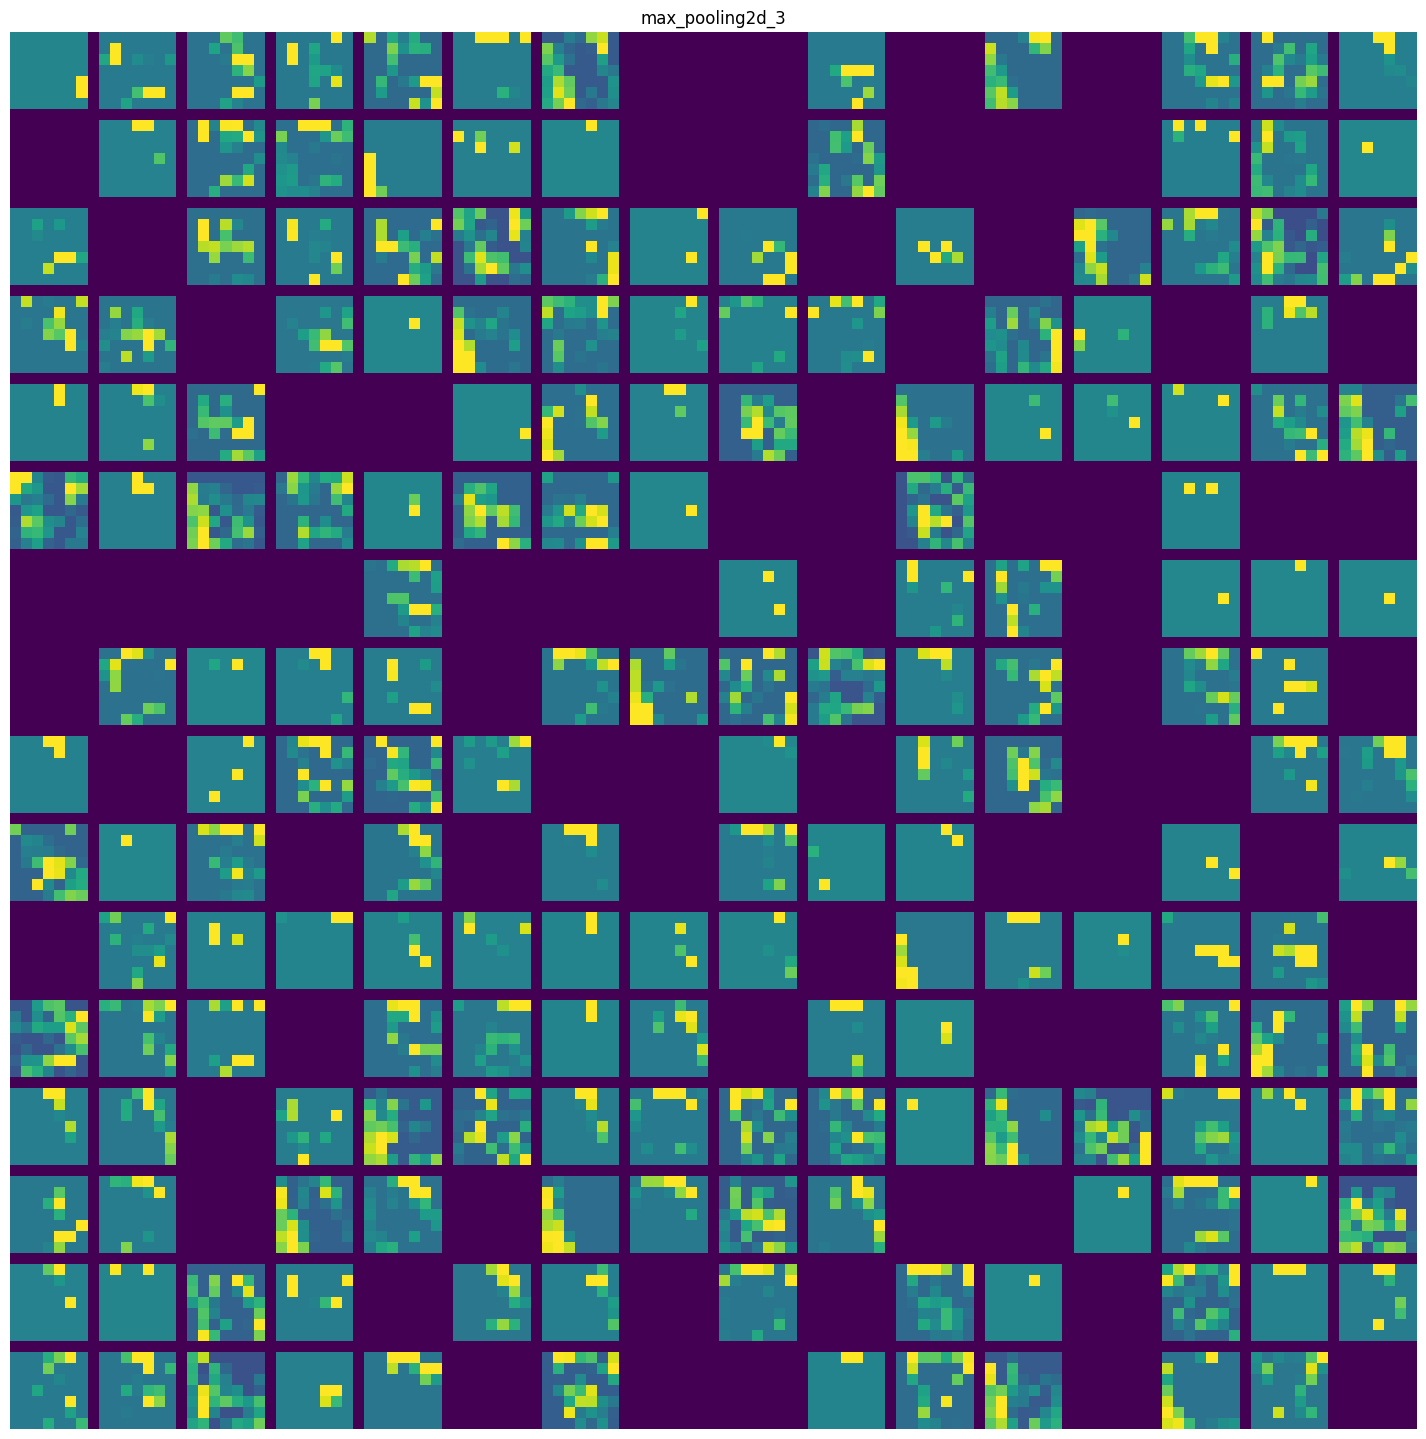

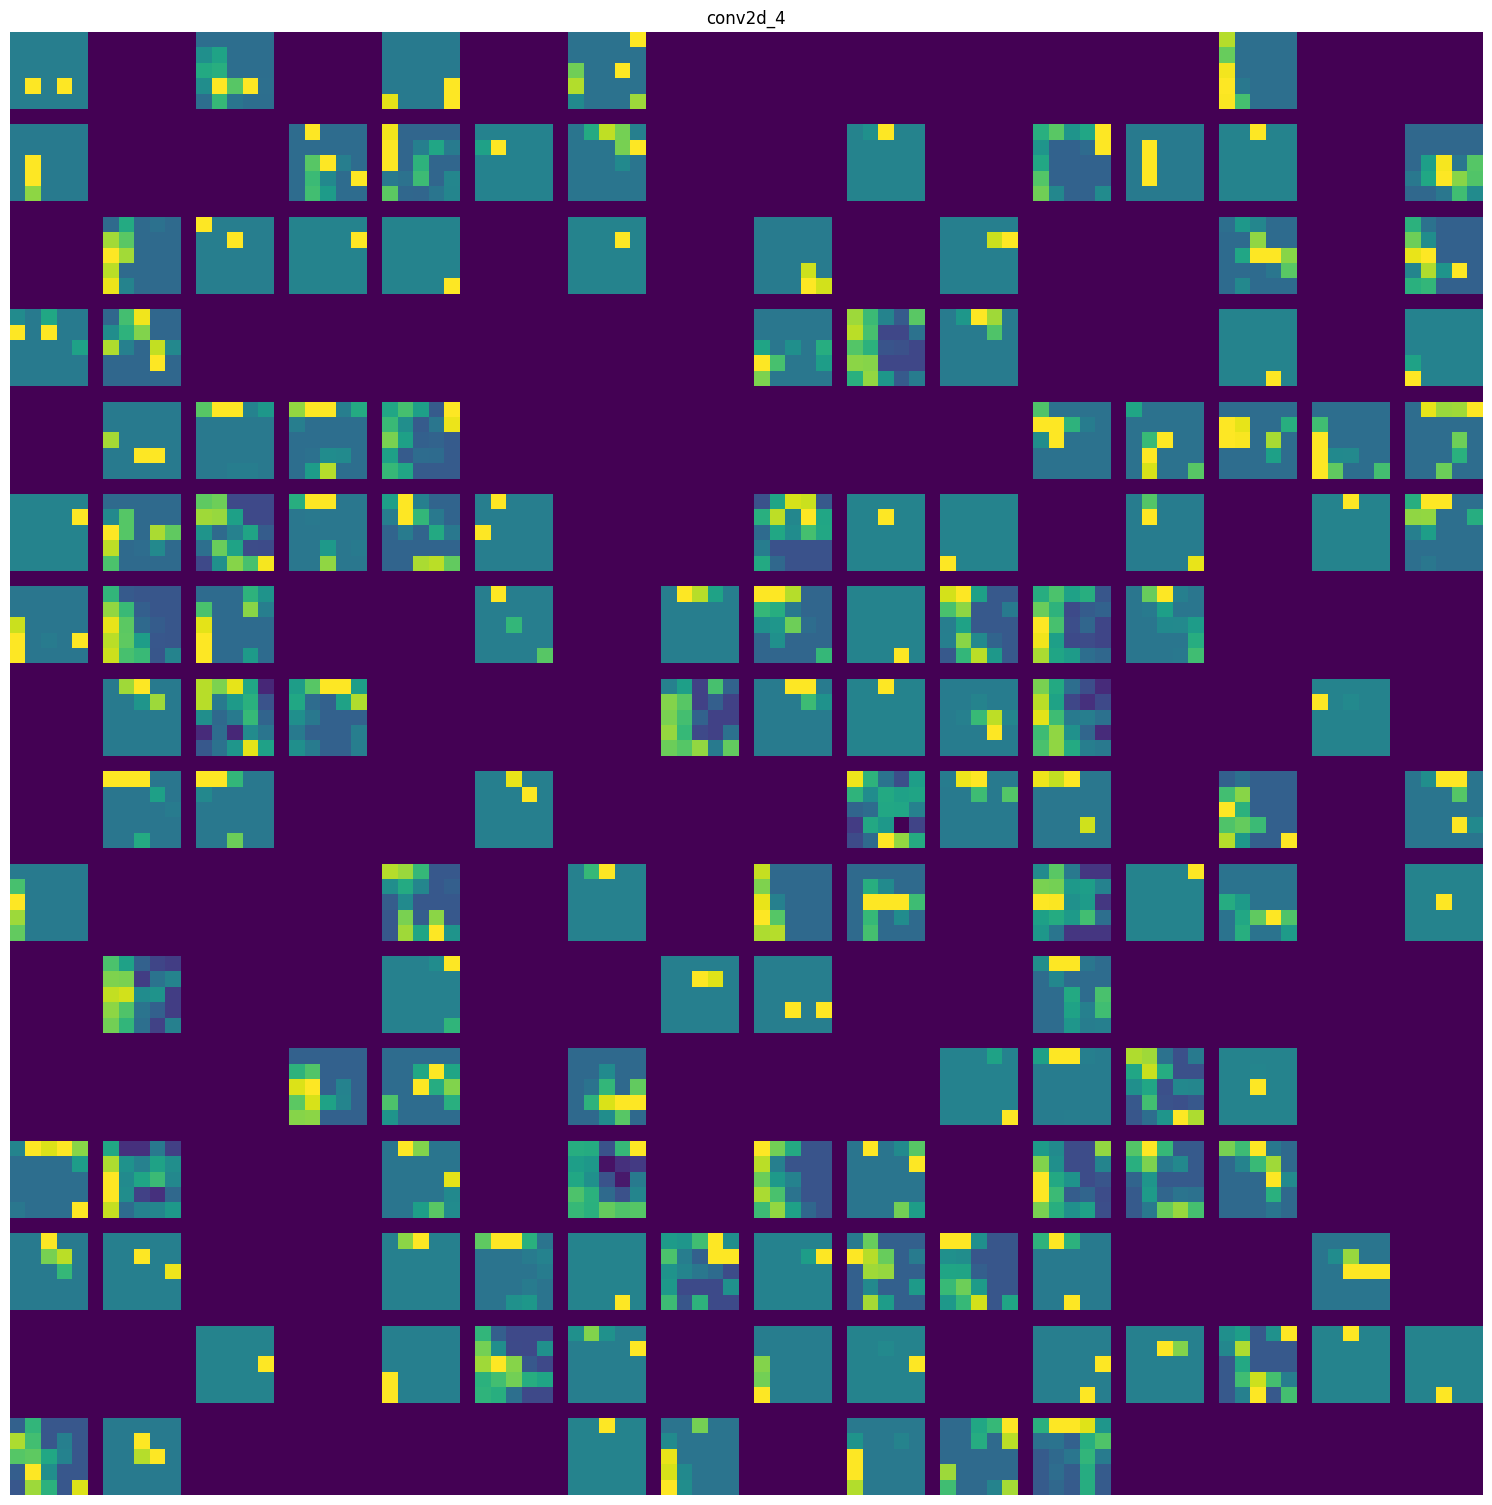

In [27]:
plot_layer_activations()

The first layers detects **edges** and **textures**; the activations retain almost all image information.

Higher activations are more abstract and encode higher-level concepts such as 'cat ear' or 'dog eye'.
    
Original **visual information** decreases and **class-related information** increases with depth.

All first layer filters are activated by the input image, but more and more filters further up are **blank**  
– the pattern encoded by the kernel isn't found in the input image.

A deep neural network effectively acts as an *information distillation pipeline*.

Relevant information is distilled – magnified and refined – whilst irrelevant information is filtered out.

#### Note

This is somewhat analogous to humans perception: we can remember which abstract objects were present in a scene (bicycle, tree...) after only a quick glance, but we might fail to remember any specific appearance.

A good test is to try and get people to draw a bicycle without checking any reference beforehand!

Our brains transform visual input into high-level concepts (i.e. abstraction) while completely filtering out irrelevant visual detail.  
They are also, in their own way, an information distillation pipeline.

----

## Visualising convnet filters

Inspect the filters learned by the convnet – what visual pattern causes a particular filter to respond.

This time we are **learning the image** (instead of net parameters).

Start with a blank image and adjust the image so that the response of a each filter is maximised.

Use gradient *ascent* this time because we are *maximising* the filter response.

**Instantiating the Xception convolutional base**

(An efficient ConvNet architecture developped by Chollet, more during the Advanced DL week.)

In [28]:
model = keras_hub.models.Backbone.from_preset(
    "xception_41_imagenet",
)
preprocessor = keras_hub.layers.ImageConverter.from_preset(
    "xception_41_imagenet",
    image_size=(180, 180),
)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [29]:
model.summary()

Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None, None, 3)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, None, None, 32) │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, None, None, 32) │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, None, None, 32) │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, None, None, 64) │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, None, None, 64) │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, None, None, 64) │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, None, None,     │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, None, None,     │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, None, None,     │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, None, None,     │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, None, None,     │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, None, None,     │          8,192 │ block1_conv2_act[0][0] │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, None, None,     │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │ 128)                   │                │                        │
├──────────────────────

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

**Printing the names of all convolutional layers in Xception**

In [30]:
for layer in model.layers:
    if isinstance(layer, (keras.layers.Conv2D, keras.layers.SeparableConv2D)):
        print(layer.name)

block1_conv1
block1_conv2
block2_sepconv1
block2_sepconv2
conv2d
block3_sepconv1
block3_sepconv2
conv2d_1
block4_sepconv1
block4_sepconv2
conv2d_2
block5_sepconv1
block5_sepconv2
block5_sepconv3
block6_sepconv1
block6_sepconv2
block6_sepconv3
block7_sepconv1
block7_sepconv2
block7_sepconv3
block8_sepconv1
block8_sepconv2
block8_sepconv3
block9_sepconv1
block9_sepconv2
block9_sepconv3
block10_sepconv1
block10_sepconv2
block10_sepconv3
block11_sepconv1
block11_sepconv2
block11_sepconv3
block12_sepconv1
block12_sepconv2
block12_sepconv3
block13_sepconv1
block13_sepconv2
conv2d_3
block14_sepconv1
block14_sepconv2


In [31]:
# Creating a feature extractor model: return the activations of a particular layer
layer_name = "block3_sepconv1"
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.input, outputs=layer.output)
print(f"activation (= new network output) shape: {feature_extractor.output_shape}")

activation (= new network output) shape: (None, None, None, 256)


**Note**

In general, when using Xception, you need to make sure your image is formatted accordingly. Here's the helper function that is used below (when we create pictures later, an equivalent method is used).

activation = feature_extractor(
    # the xception model requires transformed images (values between [0,1])
    keras.applications.xception.preprocess_input(img_tensor)
)

**Loss maximization via stochastic gradient ascent**

Where the **learning** happens!

In [32]:
def compute_loss(image, filter_index):
    activation = feature_extractor(image)
                                    # ↓ remove the edges to avoid border effects
    filter_activation = activation[:, 2:-2, 2:-2, filter_index] # select a particular filter
    return keras.ops.mean(filter_activation) # our loss is simply the mean of the activation (we will increase it)

In [33]:
# ↓ this compiles the whole function (and makes it fast!)
@tf.function
def gradient_ascent_step(image, filter_index, learning_rate):
    with tf.GradientTape() as tape:              # manual gradient calculation
        tape.watch(image)                        # we optimize the image
        loss = compute_loss(image, filter_index) # extract activations for a filter, take their mean
    grads = tape.gradient(loss, image)           # compute gradients of loss w.r.t. image (→ same shape as image!)
    grads = keras.opsnormalize(grads)            # trick: normalise them
    image += learning_rate * grads               # modify our image in the direction of the gradient (*ascent*)
    return image

**Function to generate filter visualizations**

In [34]:
img_width = 200
img_height = 200

def generate_filter_pattern(filter_index):
    iterations = 30
    learning_rate = 10.
    image = keras.random.uniform(                                        # start with a random image in the
        minval=0.4, maxval=0.6,                                          # Xception format: numbers in [0,1]
        shape=(1, img_width, img_height, 3)
    )
    # ↓ THE 'LEARNING' LOOP
    for i in range(iterations):                                          # equivalent to an epoch of training
        image = gradient_ascent_step(image, filter_index, learning_rate) # transform the image by gradient ascent
    return image[0]

**Utility function to convert a tensor into a valid image**

In [35]:
def deprocess_image(image):
    image -= keras.ops.mean(image)                 # normalise image
    image /= keras.ops.std(image)
    image *= 64                                    # values from [-1,1] to [0,255]
    image += 128
    image = keras.ops.clip(image, 0, 255)          # clip
    image = image[25:-25, 25:-25, :]               # avoid border artifacts    
    image = keras.ops.cast(image, "uint8")         # cast
    return keras.ops.convert_to_numpy(image)

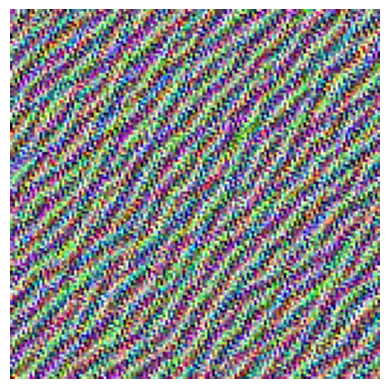

In [36]:
plt.axis("off")
plt.imshow(deprocess_image(generate_filter_pattern(filter_index=17))) # can go up to 255 (the activation earlier!)

**Generating a grid of all filter response patterns in a layer**

In [46]:
def stitch_images(all_images):
    margin = 5
    n = 8
    cropped_width = img_width - 25 * 2
    cropped_height = img_height - 25 * 2
    width = n * cropped_width + (n - 1) * margin
    height = n * cropped_height + (n - 1) * margin
    stitched_filters = np.zeros((width, height, 3))

    for i in range(n):
        for j in range(n):
            image = all_images[i * n + j]
            stitched_filters[
                (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,
                (cropped_height + margin) * j : (cropped_height + margin) * j
                + cropped_height,
                :,
            ] = image
    return stitched_filters

def generate_grid(save=False):
    all_images = []
    for filter_index in range(64):
        clear_output(wait=True)
        print(f"Processing filter {filter_index + 1}/64")
        image = deprocess_image(
            generate_filter_pattern(filter_index)
        )
        all_images.append(image)
    print()

    stitched_filters = stitch_images(all_images)

    if save:
        keras.utils.save_img(
            f"filters_for_layer_{layer_name}.png",
            stitched_filters
        )
    return stitched_filters

Processing filter 64/64



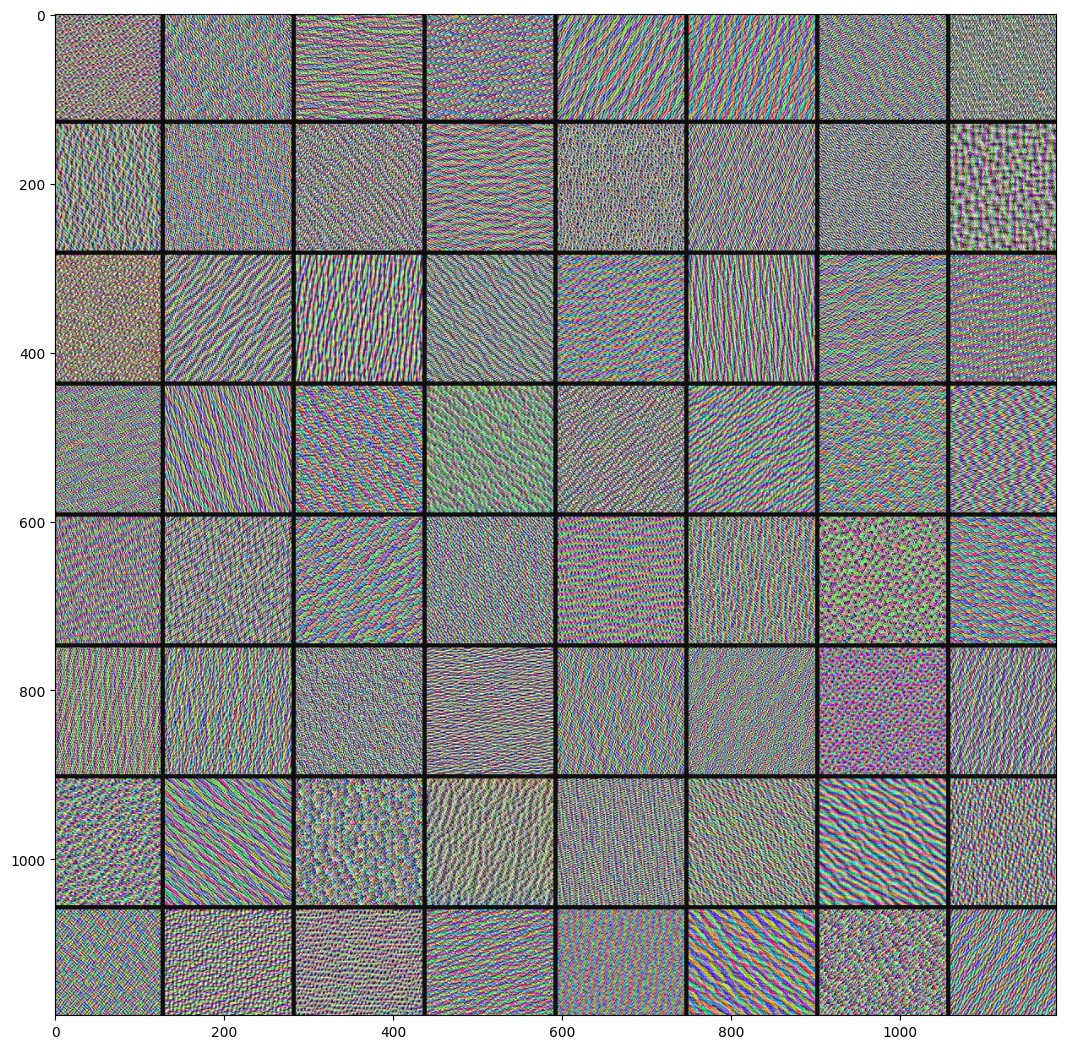

In [47]:
plt.figure(figsize=(13, 13))
plt.imshow(deprocess_image(generate_grid()))

#### To Do

This pipeline requires you to rerun all those cells manually to generate another grid! A nice encapsulation project could consist in wrapping this whole pipeline in a function, so that you can call the function passing a particular layer name, and get the grid in return! After that, the more advanced project would be to see if it is possible to generate grids for multiple layers in parallel (learnt independently, but using the functional syntax to return more than one layer with the feature extractor, and adapting the loss accordingly).

In [52]:
del model

These filter visualizations tell us much about how convnets see the world.

Each layer in a convnet learns a collection of filters.

Layer inputs can be expressed as a combination of the filters.

Filters in the convnet filter banks get increasingly complex and refined as we go proceed along the pipeline:

- The earlier-layer filters (`block2_sepconv1`) encode simple directional edges and colours (or coloured edges in some cases);
- The filters in `block7_sepconv1` encode textures made from combinations of edges and colors;
- Higher-up filter activations start resembling textures found in natural images: feathers, eyes, leaves, etc.

#### References

[OpenAI's Microscope](https://openai.com/blog/microscope/) tool explores similar visualisations for a series of models.  

The very good blog post ["The Building Blocks of Interpretability"](https://distill.pub/2018/building-blocks/) by Chris Olah et al.

----

## Visualizing heatmaps of class activation

A heatmap – the part of an image that was important in the convnet's decision process – is useful for debugging misclassifications and for object localisation.

For example: what parts of images in the Dogs vs Cats dataset are most dog-like?

### The Grad-CAM algorithm (Gradient Class Activation Map)

The core idea is that the gradient of the activation of a particular class with respect to the activation of the final conv layer is an indication of **where** and **how strongly** in the image is the network pushed towards this class.

You can think of it as a kind of *sensitivity* to specific image regions.

In [3]:
keras.utils.clear_session()

model = keras_hub.models.ImageClassifier.from_preset(
   "xception_41_imagenet",
   activation="softmax",
)

91884032/91884032 ━━━━━━━━━━━━━━━━━━━━ 39s 0us/step


Here is our example image – two African elephants:

![elephants](https://raw.githubusercontent.com/jchwenger/AI/main/lectures/05/images/chollet/creative_commons_elephant.jpg)

Preprocess...

In [4]:
IMG_PATH = keras.utils.get_file(
    fname="creative_commons_elephant.jpg",
    origin="https://raw.githubusercontent.com/jchwenger/AI/main/lectures/05/images/chollet/creative_commons_elephant.jpg"
)

img_array = keras.utils.load_img(IMG_PATH)
img_array = np.expand_dims(img, axis=0)

190269/190269 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [29]:
model = keras_hub.models.ImageClassifier.from_preset(
   "xception_41_imagenet",
   activation="softmax",
)
preds = model.predict(img_array)
print(*keras.applications.xception.decode_predictions(preds, top=3)[0], sep="\n")

('n02504458', 'African_elephant', 0.91408306)
('n01871265', 'tusker', 0.049885992)
('n02504013', 'Indian_elephant', 0.0036328638)


The top-3 predictions:

* African elephant (86.9%)
* Tusker – an elephant with very long tusks (7.6%)
* Indian elephant (2.3%)

In [6]:
model.summary()

Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 149, 149,  │        864 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 149, 149,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 149, 149,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 147, 147,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 147, 147,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 147, 147,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 147, 147,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 147, 147,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 147, 147,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 147, 147,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 147, 147,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 74, 74,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 74, 74,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 74, 74,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 74, 74,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 74, 74,    │          0 │ add[0][0]       

 Total params: 22,910,480 (87.40 MB)

 Trainable params: 22,855,952 (87.19 MB)

 Non-trainable params: 54,528 (213.00 KB)

**Setting up a model that returns the last convolutional output**

We map the input image to the activations of the last convolutional layer.

In [ ]:
img_array = model.preprocessor(img_array)

In [7]:
last_conv_layer_name = "block14_sepconv2_act" # 1. the last conv layer

# functional syntax: create a new model that returns
# the activations of a layer of our choice
last_conv_layer = model.backbone.get_layer(last_conv_layer_name)
last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

**Reapplying the classifier on top of the last convolutional output**

Then we create a model that maps the activations of the last convolutional layer to the final class predictions.

(We reproduce what happens at the very top of our net.)

In [8]:
# ↓ DEFINITION OF OUR NEW MODEL -----------------------------------------
classifier_input = last_conv_layer.output     # ← our desired input
x = classifier_input
for layer_name in ["pooler", "predictions"]:  # at the end of the loop, x is
    x = model.get_layer(layer_name)(x)        # the final classification probabilities
# ↑ ---------------------------------------------------------------------
                                # ↓ our input,      ↓ our final output
classifier_model = keras.Model(classifier_input, x)

**Retrieving the gradients of the top predicted class**

We split our network, passing the data through the convolutions, *then* the classifier, **so that we can get the gradient** (of the top predicted channel w.r.t. the last conv layer).

In [9]:
%%backend tensorflow
# THE GRADIENT

def get_top_class_gradients(img_array):
    # ↓ activations of the last conv layer
    last_conv_layer_output = last_conv_layer_model(img_array)    
    with tf.GradientTape() as tape:
        tape.watch(last_conv_layer_output)                           # ← GRADIENT
        # ↓ preds as usual, distribution over classes
        preds = classifier_model(last_conv_layer_output)
                                       # ↓([0]: no batch dim)
        top_pred_index = tf.argmax(preds[0])                         # retrieve the channel corresponding
        top_class_channel = preds[:, top_pred_index]                 # to our top predicted class (its probability)

    # ↓ gradient of       ↓ top class w.r.t. ↓ last conv layer output feature maps
    grads = tape.gradient(top_class_channel, last_conv_layer_output)
    return grads, last_conv_layer_output

grads, last_conv_layer_output = get_top_class_gradients(img_array)
grads = keras.ops.convert_to_numpy(grads)
last_conv_layer_output = keras.ops.convert_to_numpy(last_conv_layer_output)
print(f"Last conv layer shape: {last_conv_layer_output.shape}")
print(f"Gradients shape:       {grads.shape}")

Last conv layer shape: (1, 10, 10, 2048)
Gradients shape:       (1, 10, 10, 2048)


**Gradient pooling and channel-importance weighting**

In [10]:
# mean intensity of the gradient for each channel ("the importance of each channel w.r.t. the top predicted class")
pooled_grads = np.mean(grads, axis=(0, 1, 2))
            # grads shape: (1,10,10,2048), we reduce the first three dims → (2048,) numbers, one per channel
            # we had 2048 10x10 channels, and each of those becomes just *one* number (mean intensity)
            # (tf.squeeze(tf.reduce_mean(grads, axis=(1,2))) would have given the same result!)

print(f"Grads shape:           {grads.shape}")
print(f"Pooled grads shape:    {pooled_grads.shape}")

last_conv_layer_output = last_conv_layer_output[0].copy()

# THE 'LEARNING'
                                                             # We multiply each channel in the feature map array
for i in range(pooled_grads.shape[-1]):                      # by "how important this channel is" with regard
    last_conv_layer_output[:, :, i] *= pooled_grads[i]       # to the elephant class
                                                             # note: couldn't this be done using broadcasting??

heatmap = np.mean(last_conv_layer_output, axis=-1)           # The channel-wise mean of the resulting feature map
                                                             # is our heatmap of class activation

print(f"Last conv layer shape: {last_conv_layer_output.shape}")
print(f"Heatmap shape:         {heatmap.shape}")

Grads shape:           (1, 10, 10, 2048)
Pooled grads shape:    (2048,)
Last conv layer shape: (10, 10, 2048)
Heatmap shape:         (10, 10)


For visualization purpose, we will also normalize the heatmap between 0 and 1.

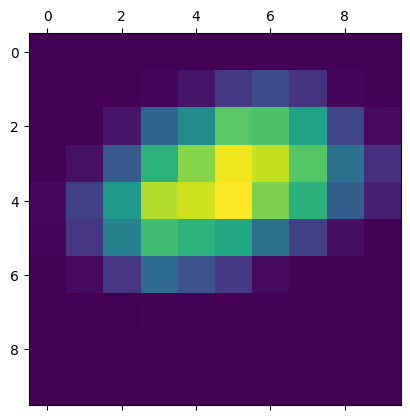

In [11]:
# rescale to [0,1]
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
# it is now a 10x10 image
plt.matshow(heatmap)
plt.show()

**Superimposing the heatmap on the original picture**

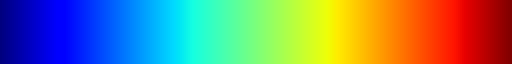

In [28]:
plt.get_cmap("jet") # our colour scheme

In [24]:
def apply_heatmap(img_path, heatmap, save=False):
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)                      # heatmap [0,1] → [0,255]

    jet = plt.get_cmap("jet")                              # turn into colour scheme
    jet_colors = jet(np.arange(256))[:, :3]                # (an array of RGBA values, removing the A)
    jet_heatmap = jet_colors[heatmap]                      # (use the heatmap as indices)

    jet_heatmap = keras.utils.array_to_img(jet_heatmap) # resize the heatmap to the pic dimension
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * 0.4 + img             # mix image and heatmap (0.4 is the strength)
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    plt.axis("off")
    plt.imshow(superimposed_img)

    if save:
        save_path = "elephant_cam.jpg"
        superimposed_img.save(save_path)

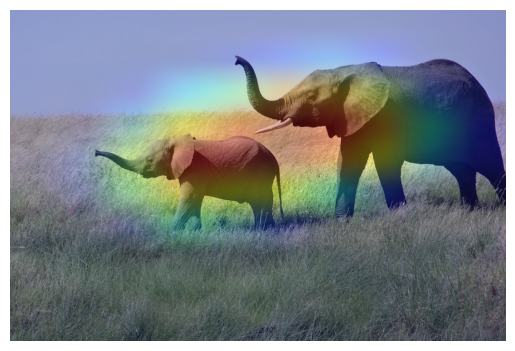

In [25]:
apply_heatmap(IMG_PATH, heatmap)

The heat map indicates where the elephant(s) is(are) located, and how intensely the network thought it had seen an African elephant there.

----

## Summary

#### Convnets

- Convnets have long been the best tool for image classification  
  (now somewhat displaced by Vision Transformers);
- Convnets learn a heirarchy of modular patterns;
- These patterns can be visualised and are meaningful to us, unlike with Dense nets.

#### Visualisations

- **Intermediate activations**: what do feature maps look like;
- **Convnet filters**: *optimize images* to activate filters maximally, using gradient ascent;
- **Heatmaps of class activations**: what part of an image most influences a network in its class choice

#### Workflows

- **Data augmentation** combats overfitting on small datasets;
- **Pretrained convnets** can be deployed even if the target classes are quite different;
- For that, retrain a **new top classifier** (dense net), using:
  - **Feature extraction** (the new classifier is a separate net);
  - **A frozen base** (to train the new classifier along with it);
  - **Finetune some layers** (unfreeze them) and train them with the new classifier (but train it first with the whole net frozen).